# Soil Layering by Pile Driving Records

This notebook aims to explore various ML approaches to automatically split strata into multiple layers based on pile driving records.

Author: Zhiyan Jiang (linkedIn.com/zhiyanjiang)

In [20]:
# import external libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: configurations

In [21]:
from importData import importCsv

fileName = "Driving data\Blowcounts.csv"
random_state = None

# numberClusters: the number of layers anticipated in result
numberClusters = 5

# horizontal and vertical labels of the data
dataLabels = ["Blows/ft", "Depth [ft]"]

# Step 2: import data

In [22]:
# Import data
data, nRow, nCol = importCsv(fileName)


Row number is: 75; Column number is: 35
Pile number is: 34


[ 0.52941176  0.52941176  0.32352941  0.29411765  0.52941176  0.38235294
  0.14705882  0.29411765  0.32352941  0.44117647  0.38235294  0.64705882
  0.58823529  1.85294118  3.52941176  9.94117647 11.44117647 15.64705882
 17.         14.94117647 22.32352941 21.02941176 18.88235294 16.32352941
 13.91176471 11.55882353 12.02941176 11.32352941 11.41176471 10.82352941
  9.91176471 11.08823529 10.55882353 11.73529412 12.55882353 11.11764706
 12.44117647 12.35294118 12.41176471 11.82352941 11.44117647 13.02941176
 13.52941176 12.82352941 11.79411765 12.20588235 12.94117647 13.44117647
 13.08823529 12.67647059 12.70588235 13.17647059 13.91176471 13.32352941
 12.55882353 13.52941176 13.44117647 13.11764706 13.5        16.67647059
 13.32352941 15.20588235 15.17647059 15.97058824 15.55882353 16.41176471
 17.55882353 19.41176471 19.87878788 24.36363636 28.16129032 29.16129032
 28.32258065 28.61290323 30.08      ]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 

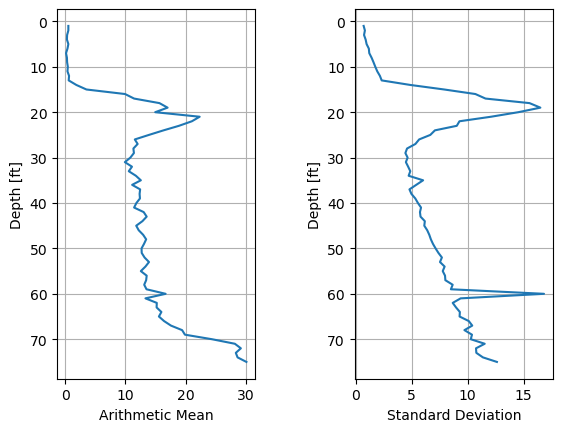

In [23]:
# Plot arithmetical mean and standard deviations in terms of depth
from plot import *
plotMeanDeviation(data)

# Step 3: Pre-processing

### In the original data, first column is depth [ft], each of the rest columns refers to incremental blowcounts of a pile  

In [24]:
# Aggregate all {depth, incremental blow} data
from aggregate import *

aggregateFlag = True
dataInputToAggregate = [aggregateFlag, data]

dataAggregate = aggregate_DepthVsOneFeature(dataInputToAggregate)


Data is aggregated.
The aggregated shape is: (2550, 2)


In [25]:
# remove nan values
from remove import *
removeNanFlag = True
dataInputToRemoveNan = [removeNanFlag, dataAggregate]

dataAggregateNan = removeNan(dataInputToRemoveNan)

Before removeNan, the row number is 2550
After removeNan, the row number is 2527


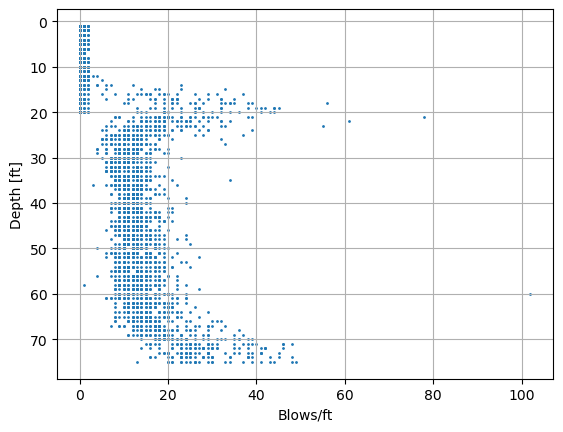

In [26]:
# Plot original incremental blowcount data
from plot import *

plotAggregate(dataAggregateNan, dataLabels, 1)

75


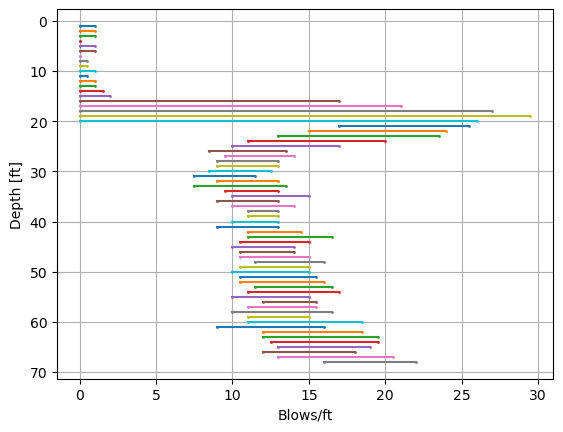

In [ ]:
# Due to significant overlap in data points, plot 25% and 75% percentile
def plotPercentile(data, lowerPercentile, upperPercentile):
    # This function plots the lower and upper percentile
    # data is dataframe
    dataNumpy = data.to_numpy()
    lowerPercent = np.percentile(dataNumpy, lowerPercentile, axis = 1)
    upperPercent = np.percentile(dataNumpy, upperPercentile, axis = 1)

    rowCount = dataNumpy.shape[0]

    for i in np.arange(rowCount):
        xCoords = np.array([lowerPercent[i], upperPercent[i]])
        yCoords = np.array([dataNumpy[i][0], dataNumpy[i][0]])

        plt.plot(xCoords, yCoords, marker = '.', markersize = 2)
    
    plt.xlabel("Blows/ft")
    plt.ylabel("Depth [ft]")
    plt.gca().invert_yaxis()
    plt.grid(True)

print(f"Below is blow counts varying between 25% and 75%")
plotPercentile(data, 25, 75)

In [8]:
referenceVector = np.max(dataAggregateNan, axis = 0)



## Step 4: Clustering 

### 4.1 Agglomerative Clustering

Below is the results by Agglomerative clustering


AgglomerativeClustering(n_clusters=5)

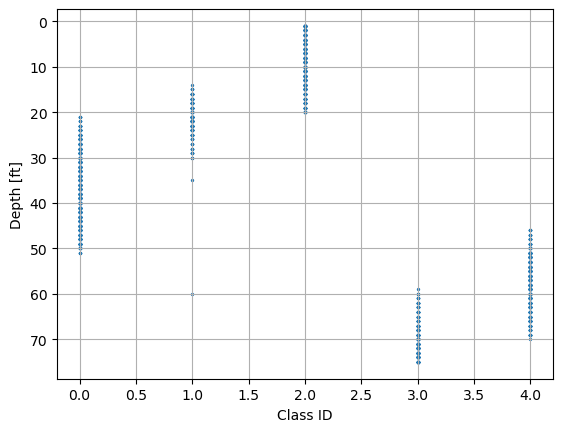

In [9]:
from performAgglomerativeClustering import *
# AgglomerativeClustering input
performAgglomerative = True
normalizationAgg = False
linkageStr = 'ward'
agglomerativeClusteringInput = [performAgglomerative, normalizationAgg, linkageStr, numberClusters, referenceVector ] # [perform?, normalized?]

performAgglomerativeClustering(agglomerativeClusteringInput, dataAggregateNan)

### 4.2 K-Means Clustering

Below is the results by Kmeans clustering


1

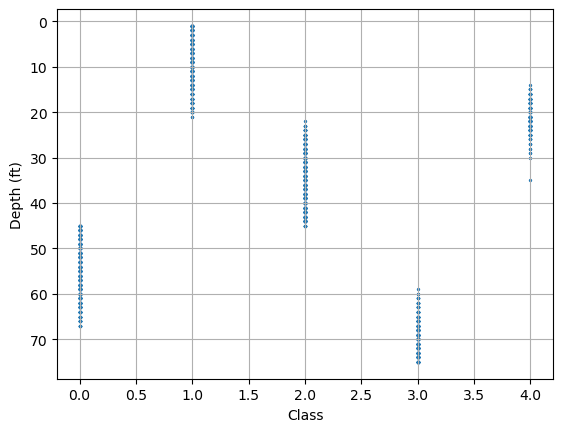

In [10]:
# Use Kmeans
from performKmeansClustering import *

performKmeansFlag = True
n_init = "auto"
kmeansClusteringInput = [performKmeansFlag, numberClusters, random_state, n_init]

performKmeans(kmeansClusteringInput, dataAggregateNan)


### 4.3 Bisect-KMeans Clustering

Below is the results by Bisecting K-Means clustering


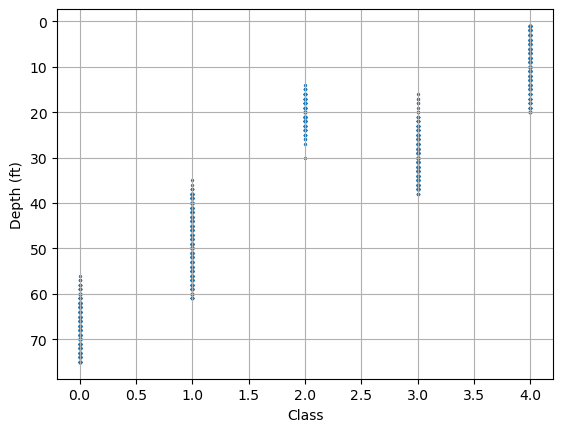

In [11]:
# Use Bisect-Kmeans
from performBisectKmeansClustering import *

performBisectKmeansFlag = True
bisectKmeansInput = [performBisectKmeansFlag, numberClusters, random_state]

performBisectKmeans(bisectKmeansInput, dataAggregateNan)


### 4.4 Gaussian Mixture Model

Perform Gaussian Mixture Model. The number of components (n_components) is essentially numberClusters.

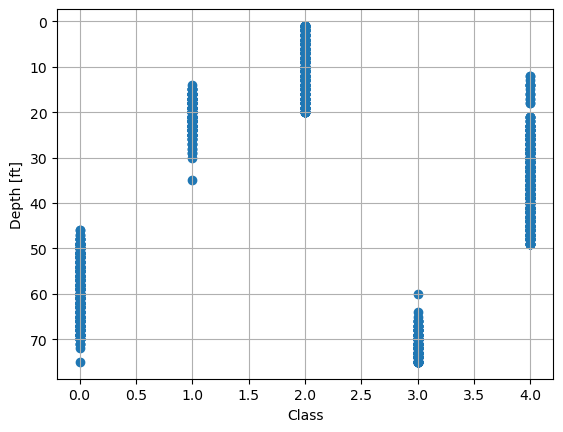

In [12]:
# perform Gaussian Mixture model
from performGaussianMixture import *
performGaussianMixtureFlag = True
gmObj = fitGaussianMixture(performGaussianMixtureFlag, numberClusters, random_state, dataAggregateNan)

gmResults = predictGaussianMixture(gmObj, dataAggregateNan)
gmResults
plotGaussianMixture(dataAggregateNan[:,0], gmResults)

Comments on the results by Gaussian Mixture Model: <br> <br>
The results by GMM do not differentiate soil layers effectively. At most depths, multiple class IDs are assigned to the same depth. Only the top layer (blowcounts = 0) is distinct.

### 4.5 Decision Tree Regression

Node 0: Feature index 0, Threshold 15.5
Node 2: Feature index 0, Threshold 69.5
Node 3: Feature index 0, Threshold 63.5
Node 5: Feature index 0, Threshold 24.5
The score by Decision tree regression: 0.5481385455040793
Below is the results by Decision tree regression
Node 0: Feature index 0, Threshold 15.5
Node 2: Feature index 0, Threshold 69.5
Node 3: Feature index 0, Threshold 63.5
Node 5: Feature index 0, Threshold 24.5
The layer interface depths resulting from Decision tree method is below:


array([15.5, 24.5, 63.5, 69.5])

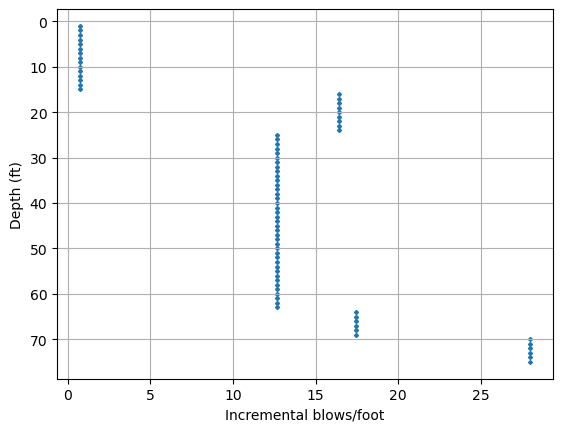

In [13]:
# Use Decision Tree
from performDecisionTreeClustering import *
performDecisionTreeFlag = True
decisionTreeInput = [performDecisionTreeFlag, numberClusters]

decisionTreeObj = performDecisionTree(decisionTreeInput, dataAggregateNan)

decisionTreeCriteria = getDecisionTreeCriteria(decisionTreeObj)
print(f"The layer interface depths resulting from Decision tree method is below:")
decisionTreeCriteria

Comments on the results by Decision Tree Regression<br><br>
Five layers are clearly illustrated and the regression result by the decision tree match the trend of the original data. However, the down side of Decision Tree is that it does not include any randomness. Once number of leaf nodes is confirmed, the result is ensure the same.

### 4.5 Random Forest Regression

The score by Random Forest: 0.5548961698294388
Below is the results by Random forest regression


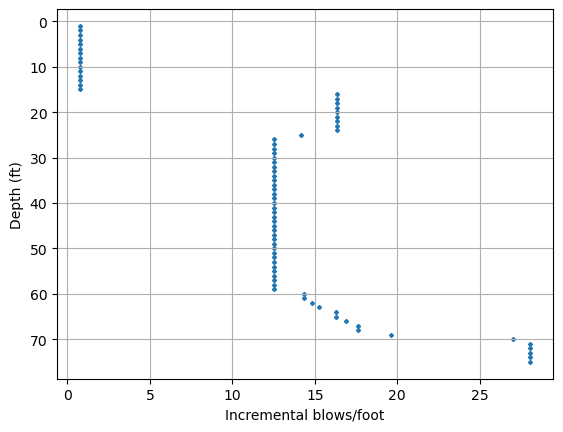

In [14]:
# Perform Random Forest
from performRandomForestClustering import *
performRandomForestFlag = True
numberTrees = 10
maxLeafNodes = numberClusters
randomForestInput = [performRandomForestFlag, numberTrees, maxLeafNodes]

randomForestObj = performRandomForest(randomForestInput, dataAggregateNan)

# plot random forest result
plotRandomForestResult(randomForestObj, dataAggregate)

### Extract layer interface depths from non-leaf nodes

Tree 0:
Node 0: Feature 0, Threshold 15.5
Node 2: Feature 0, Threshold 69.5
Node 3: Feature 0, Threshold 59.5
Node 5: Feature 0, Threshold 24.5
Tree 1:
Node 0: Feature 0, Threshold 15.5
Node 2: Feature 0, Threshold 69.5
Node 3: Feature 0, Threshold 66.5
Node 5: Feature 0, Threshold 24.5
Tree 2:
Node 0: Feature 0, Threshold 15.5
Node 2: Feature 0, Threshold 68.5
Node 3: Feature 0, Threshold 25.5
Node 6: Feature 0, Threshold 59.5
Tree 3:
Node 0: Feature 0, Threshold 15.5
Node 2: Feature 0, Threshold 69.5
Node 3: Feature 0, Threshold 25.5
Node 6: Feature 0, Threshold 62.5
Tree 4:
Node 0: Feature 0, Threshold 15.5
Node 2: Feature 0, Threshold 69.5
Node 3: Feature 0, Threshold 59.5
Node 5: Feature 0, Threshold 25.5
Tree 5:
Node 0: Feature 0, Threshold 15.5
Node 2: Feature 0, Threshold 68.5
Node 3: Feature 0, Threshold 63.5
Node 5: Feature 0, Threshold 25.5
Tree 6:
Node 0: Feature 0, Threshold 15.5
Node 2: Feature 0, Threshold 70.5
Node 3: Feature 0, Threshold 65.5
Node 5: Feature 0, Thresho

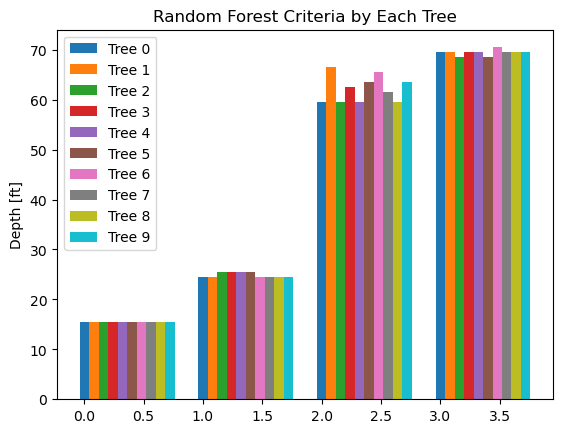

In [15]:
# plot Random forest results using bar chart
randomForestCriteria = getRandomForestCriteria(randomForestObj)

plotRandomForestCriteria(randomForestCriteria)

# reduce randomForestCriteria as median
randomForestCriteriaReduced = randomForestCriteriaMedian(randomForestCriteria)
print(f"The reduced Random Forest criteria is: \n{randomForestCriteriaReduced}") 

Comments on the results by Random Forest Regression<br><br>
Five layers are clearly illustrated and the regression result by the decision tree match the trend of the original data. Compared with decision tree, the bootstrap sampling introduces randomness, which helps exclude outliners in the original data. For example, blowcounts of 101 at 60 ft deep is likely to be an error and may be excluded with bootstrap. In addition, reviewing results by each tree helps showing the variability of each interface. For example, the interface at 15 ft and 70 ft have minimum variation, while the ones 60 ft have largest variation. Such variations not only reveal uncertainties, but also enlight on another possible layering option.

### The following block is for sensitivity analysis on number of layers, i.e., number of leaf nodes

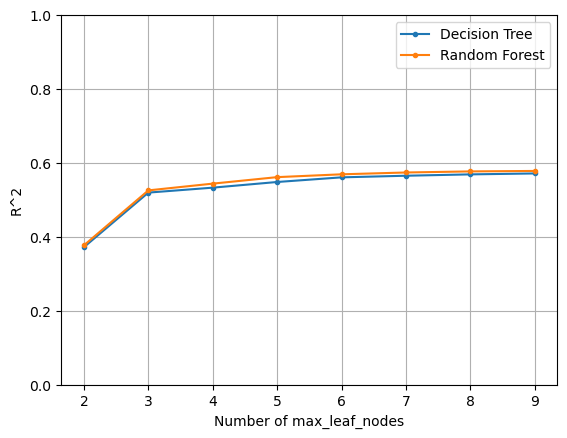

In [16]:
# test multiple max_leaf_nodes
from testMaxLeafNodes import *
testDecisionTreeFlag = True
testRandomForestFlag = True
testObjFlags = [testDecisionTreeFlag, testRandomForestFlag]
leafNodesRange = [2, 10]

testMaxLeafNodes(leafNodesRange, testObjFlags, dataAggregateNan)

## Step 5: Apply the random forest result to generate simplified layer data

### After dividing the strata, consolidate blowcounts for each layer. Consolidation method: take the median value for that layer.

In [17]:
from applyCriteria import *
# get strata index of each data point
strataIndex = getStrataIndex(randomForestCriteriaReduced, dataAggregateNan)

# group all data points based on strataIndex
dataAggregateNanGrouped = groupStrata(strataIndex, dataAggregateNan)

roundIntegerFlag = [True]
simplifiedStrata = simplyStrata(dataAggregateNanGrouped, roundIntegerFlag)
print(f"The consolidated blowcounts of each layer is: ")
simplifiedStrata

The consolidated blowcounts of each layer is: 


array([[ 1.],
       [16.],
       [13.],
       [17.],
       [28.]])

In [18]:
# Obtain the upper and lower depths of each layer
randomForestCriteriaReducedConverted = convertCriteria(randomForestCriteriaReduced, np.max(dataAggregateNan[:, 0])) 
print(f"The converted random forest criteria is below. Each row denotes upper and lower depths of a layer")
randomForestCriteriaReducedConverted 

The converted random forest criteria is below. Each row denotes upper and lower depths of a layer


array([[ 0. , 15.5],
       [15.5, 24.5],
       [24.5, 62. ],
       [62. , 69.5],
       [69.5, 75. ]])

### Plot the consolidated incremental blows vs Depth

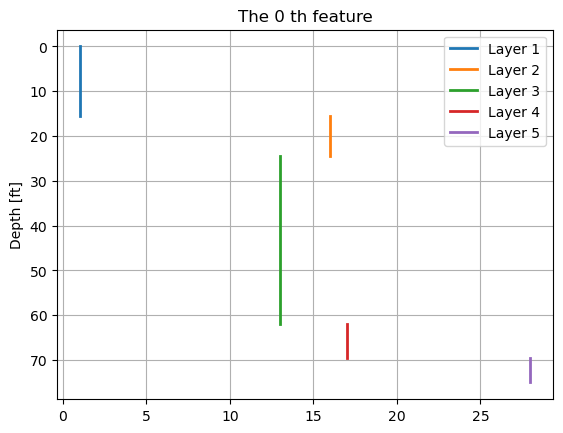

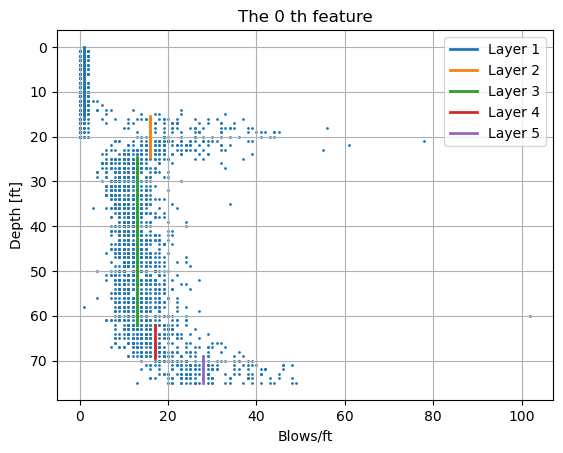

In [19]:
# plot piecewise blowcounts for each layer
from plot import *

plotSimplifiedStrata(simplifiedStrata, randomForestCriteriaReducedConverted )

# plot piecewise blowcounts on top of original data
plt.figure()
plt.gca().invert_yaxis()
plotAggregate(dataAggregateNan, dataLabels, 1)
plotSimplifiedStrata(simplifiedStrata, randomForestCriteriaReducedConverted )


## Step 6: Conclusions
Pile driving records of 34 piles are analyzed to determine soil layering. Six clustering and regression techniques are studied, including agglomerative clustering, K-Means clustering, bisecting K-Means clustering, Gaussian mixture model, decision tree regression, and random forests regression. Among them, random forests yield the best layering results that satisfy the constraint requirement. The study in this project lies foundations for determining geotechnical soil strata using machine learning techniques and provides insights into clustering geotechnical data with higher dimensions.

### End